# Plot Fig 8

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import pandas as pd
import requests
import io

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import cartopy.feature as cfeature
import matplotlib.mlab as mlab
import cartopy.io.shapereader as shapereader
from dask.diagnostics import ProgressBar
import matplotlib
import os

from scipy import stats

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = 'Tahoma' 
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['pdf.fonttype'] = 42

import sys

### Define functions

In [2]:
def calculate_cv(ds):
    ds['CV'] = ds.PRECT_mm.std(dim='year') / ds.PRECT_mm.mean(dim='year')
    return ds

In [3]:
def calculate_map(ds):
    ds['MAP'] = ds.PRECT_mm.mean(dim='year')
    return ds

In [11]:
def mean_intensity_severity_percentage(ds, threshold_start, threshold_end):
    ds_clim = ds.where((ds['year'] >= threshold_start) & (ds['year'] <= threshold_end), drop=True)
    ds['droughts_2s2e_intensity_pc'] = ds.droughts_2s2e_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_2s2e_intensity_pc_mean'] = ds.droughts_2s2e_intensity_pc.mean(dim='year') * -100
    ds['droughts_2s2e_severity_pc'] = ds.droughts_2s2e_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_2s2e_severity_pc_mean'] = ds.droughts_2s2e_severity_pc.mean(dim='year') * -100

    ds['droughts_median_intensity_pc'] = ds.droughts_median_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_median_intensity_pc_mean'] = ds.droughts_median_intensity_pc.mean(dim='year') * -100
    ds['droughts_median_severity_pc'] = ds.droughts_median_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_median_severity_pc_mean'] = ds.droughts_median_severity_pc.mean(dim='year') * -100
    
    ds['droughts_20perc_intensity_pc'] = ds.droughts_20perc_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_20perc_intensity_pc_mean'] = ds.droughts_20perc_intensity_pc.mean(dim='year') * -100
    ds['droughts_20perc_severity_pc'] = ds.droughts_20perc_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_20perc_severity_pc_mean'] = ds.droughts_20perc_severity_pc.mean(dim='year') * -100
    
    ds['droughts_120pc_2med_intensity_pc'] = ds.droughts_120pc_2med_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_120pc_2med_intensity_pc_mean'] = ds.droughts_120pc_2med_intensity_pc.mean(dim='year') * -100
    ds['droughts_120pc_2med_severity_pc'] = ds.droughts_120pc_2med_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_120pc_2med_severity_pc_mean'] = ds.droughts_120pc_2med_severity_pc.mean(dim='year') * -100
    
    ds['droughts_220pc_1med_intensity_pc'] = ds.droughts_220pc_1med_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_220pc_1med_intensity_pc_mean'] = ds.droughts_220pc_1med_intensity_pc.mean(dim='year') * -100
    ds['droughts_220pc_1med_severity_pc'] = ds.droughts_220pc_1med_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_220pc_1med_severity_pc_mean'] = ds.droughts_220pc_1med_severity_pc.mean(dim='year') * -100

In [13]:
def process_lm_files_pre1850(ds):
    ds_pre1850 = ds.where(ds.year < 1850, drop=True)
    ds_pre1850['droughts_2s2e_max'] = ds_pre1850.droughts_2s2e.max(dim='year', skipna=True)
    ds_pre1850['droughts_2s2e_mean'] = ds_pre1850.droughts_2s2e.mean(dim='year', skipna=True)
    ds_pre1850['droughts_2s2e_std'] = ds_pre1850.droughts_2s2e.std(dim='year', skipna=True)
    ds_pre1850['droughts_2s2e_intensity_pc_mean'] = ds_pre1850.droughts_2s2e_intensity_pc.mean(dim='year') * -100
    ds_pre1850['droughts_2s2e_severity_pc_mean'] = ds_pre1850.droughts_2s2e_severity_pc.mean(dim='year') * -100
    ds_pre1850['CV'] = ds_pre1850.PRECT_mm.std(dim='year') / ds_pre1850.PRECT_mm.mean(dim='year')
    ds_pre1850['droughts_2s2e_no_of_events'] = np.count_nonzero(~np.isnan(ds_pre1850.droughts_2s2e))
    ds_pre1850['droughts_2s2e_no_events_100yrs'] = (ds_pre1850.droughts_2s2e_no_of_events / len(ds_pre1850.year)) * 100
    ds_pre1850['droughts_2s2e_sum_100yrs'] = (ds_pre1850.drought_years_2s2e.sum(dim='year') / len(ds_pre1850.year)) * 100
    return ds_pre1850

In [17]:
def no_events_100yrs(ds):
    ds['droughts_2s2e_no_events_100yrs'] = (ds.droughts_2s2e_no_of_events / len(ds.year)) * 100
    ds['droughts_2s2e_sum_100yrs'] = (ds.drought_years_2s2e.sum(dim='year') / len(ds.year)) * 100

### Import files

In [4]:
hist_dir = 'D:/for_georgy/mdb/historical_1900'

bcc_precip_hist_mdb        = xr.open_dataset('%s/bcc_precip_hist_annual_mdb.nc' % hist_dir)
ccsm4_precip_hist_mdb      = xr.open_dataset('%s/ccsm4_precip_hist_annual_mdb.nc' % hist_dir)
csiro_mk3l_precip_hist_mdb = xr.open_dataset('%s/csiro_mk3l_precip_hist_annual_mdb.nc' % hist_dir)
fgoals_s2_precip_hist_mdb  = xr.open_dataset('%s/fgoals_s2_precip_hist_annual_mdb.nc' % hist_dir)
giss_28_precip_hist_mdb    = xr.open_dataset('%s/giss_28_precip_hist_annual_mdb.nc' % hist_dir)
hadcm3_precip_hist_mdb     = xr.open_dataset('%s/hadcm3_precip_hist_annual_mdb.nc' % hist_dir)
ipsl_precip_hist_mdb       = xr.open_dataset('%s/ipsl_precip_hist_annual_mdb.nc' % hist_dir)
miroc_precip_hist_mdb      = xr.open_dataset('%s/miroc_precip_hist_annual_mdb.nc' % hist_dir)
mpi_precip_hist_mdb        = xr.open_dataset('%s/mpi_precip_hist_annual_mdb.nc' % hist_dir)
mri_precip_hist_mdb        = xr.open_dataset('%s/mri_precip_hist_annual_mdb.nc' % hist_dir)
ff1_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff1_precip_hist_annual_mdb.nc' % hist_dir)
ff2_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff2_precip_hist_annual_mdb.nc' % hist_dir)
ff3_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff3_precip_hist_annual_mdb.nc' % hist_dir)
ff4_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff4_precip_hist_annual_mdb.nc' % hist_dir)
ff5_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff5_precip_hist_annual_mdb.nc' % hist_dir)
ff6_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff6_precip_hist_annual_mdb.nc' % hist_dir)
ff7_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff7_precip_hist_annual_mdb.nc' % hist_dir)
ff8_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff8_precip_hist_annual_mdb.nc' % hist_dir)
ff9_precip_hist_mdb        = xr.open_dataset('%s/cesmlme-ff9_precip_hist_annual_mdb.nc' % hist_dir)
ff10_precip_hist_mdb       = xr.open_dataset('%s/cesmlme-ff10_precip_hist_annual_mdb.nc' % hist_dir)
ff11_precip_hist_mdb       = xr.open_dataset('%s/cesmlme-ff11_precip_hist_annual_mdb.nc' % hist_dir)
ff12_precip_hist_mdb       = xr.open_dataset('%s/cesmlme-ff12_precip_hist_annual_mdb.nc' % hist_dir)
ff13_precip_hist_mdb       = xr.open_dataset('%s/cesmlme-ff13_precip_hist_annual_mdb.nc' % hist_dir)
giss_all_precip_hist_mdb   = xr.open_dataset('%s/giss_all_precip_hist_annual_mdb.nc' % hist_dir)

awap_masked_annual_mdb     = xr.open_dataset('%s/awap_masked_annual_mdb.nc' % hist_dir)

In [5]:
lm_dir = 'D:/for_georgy/mdb/lastmillennium_threshold_1900-2000'

bcc_precip_lm_mdb        = xr.open_dataset('%s/bcc_precip_lm_annual_mdb.nc' % lm_dir)
ccsm4_precip_lm_mdb      = xr.open_dataset('%s/ccsm4_precip_lm_annual_mdb.nc' % lm_dir)
csiro_mk3l_precip_lm_mdb = xr.open_dataset('%s/csiro_mk3l_precip_lm_annual_mdb.nc' % lm_dir)
fgoals_s2_precip_lm_mdb  = xr.open_dataset('%s/fgoals_s2_precip_lm_annual_mdb.nc' % lm_dir)
giss_28_precip_lm_mdb    = xr.open_dataset('%s/giss_28_precip_lm_annual_mdb.nc' % lm_dir)
hadcm3_precip_lm_mdb     = xr.open_dataset('%s/hadcm3_precip_lm_annual_mdb.nc' % lm_dir)
ipsl_precip_lm_mdb       = xr.open_dataset('%s/ipsl_precip_lm_annual_mdb.nc' % lm_dir)
miroc_precip_lm_mdb      = xr.open_dataset('%s/miroc_precip_lm_annual_mdb.nc' % lm_dir)
mpi_precip_lm_mdb        = xr.open_dataset('%s/mpi_precip_lm_annual_mdb.nc' % lm_dir)
mri_precip_lm_mdb        = xr.open_dataset('%s/mri_precip_lm_annual_mdb.nc' % lm_dir)
ff1_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff1_precip_lm_annual_mdb.nc' % lm_dir)
ff2_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff2_precip_lm_annual_mdb.nc' % lm_dir)
ff3_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff3_precip_lm_annual_mdb.nc' % lm_dir)
ff4_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff4_precip_lm_annual_mdb.nc' % lm_dir)
ff5_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff5_precip_lm_annual_mdb.nc' % lm_dir)
ff6_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff6_precip_lm_annual_mdb.nc' % lm_dir)
ff7_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff7_precip_lm_annual_mdb.nc' % lm_dir)
ff8_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff8_precip_lm_annual_mdb.nc' % lm_dir)
ff9_precip_lm_mdb        = xr.open_dataset('%s/cesmlme-ff9_precip_lm_annual_mdb.nc' % lm_dir)
ff10_precip_lm_mdb       = xr.open_dataset('%s/cesmlme-ff10_precip_lm_annual_mdb.nc' % lm_dir)
ff11_precip_lm_mdb       = xr.open_dataset('%s/cesmlme-ff11_precip_lm_annual_mdb.nc' % lm_dir)
ff12_precip_lm_mdb       = xr.open_dataset('%s/cesmlme-ff12_precip_lm_annual_mdb.nc' % lm_dir)
ff13_precip_lm_mdb       = xr.open_dataset('%s/cesmlme-ff13_precip_lm_annual_mdb.nc' % lm_dir)

In [6]:
cntl_dir = 'D:/for_georgy/mdb/control'

bcc_cntl_mdb        = xr.open_dataset('%s/bcc_annual_cntl_mdb.nc' % cntl_dir)
ccsm4_cntl_mdb      = xr.open_dataset('%s/ccsm4_annual_cntl_mdb.nc' % cntl_dir)
csiro_mk3l_cntl_mdb = xr.open_dataset('%s/csiro_mk3l_annual_cntl_mdb.nc' % cntl_dir)
fgoals_s2_cntl_mdb  = xr.open_dataset('%s/fgoals_s2_annual_cntl_mdb.nc' % cntl_dir)
giss_1_cntl_mdb     = xr.open_dataset('%s/giss_1_annual_cntl_mdb.nc' % cntl_dir)
giss_2_cntl_mdb     = xr.open_dataset('%s/giss_2_annual_cntl_mdb.nc' % cntl_dir)
giss_3_cntl_mdb     = xr.open_dataset('%s/giss_3_annual_cntl_mdb.nc' % cntl_dir)
giss_41_cntl_mdb     = xr.open_dataset('%s/giss_41_annual_cntl_mdb.nc' % cntl_dir)
hadcm3_cntl_mdb     = xr.open_dataset('%s/hadcm3_annual_cntl_mdb.nc' % cntl_dir)
ipsl_cntl_mdb       = xr.open_dataset('%s/ipsl_annual_cntl_mdb.nc' % cntl_dir)
miroc_cntl_mdb      = xr.open_dataset('%s/miroc_annual_cntl_mdb.nc' % cntl_dir)
mpi_cntl_mdb        = xr.open_dataset('%s/mpi_annual_cntl_mdb.nc' % cntl_dir)
mri_cntl_mdb        = xr.open_dataset('%s/mri_annual_cntl_mdb.nc' % cntl_dir)
cesmlme_cntl_mdb    = xr.open_dataset('%s/cesmlme_annual_cntl_mdb.nc' % cntl_dir)

### Take 500 years from each control run so they're comparable

In [7]:
ccsm4_cntl_mdb.coords['year'] = np.arange(1, 1052, 1)
ccsm4_cntl_mdb = ccsm4_cntl_mdb.sel(year=slice(1, 500))
ccsm4_cntl_mdb['droughts_2s2e_no_of_events'] = ccsm4_cntl_mdb.droughts_2s2e_no_of_events/(1052/500)

csiro_mk3l_cntl_mdb = csiro_mk3l_cntl_mdb.sel(year=slice(1, 500))
csiro_mk3l_cntl_mdb['droughts_2s2e_no_of_events'] = csiro_mk3l_cntl_mdb.droughts_2s2e_no_of_events/(1000/500)

fgoals_s2_cntl_mdb.coords['year'] = np.arange(1, 502, 1)
fgoals_s2_cntl_mdb = fgoals_s2_cntl_mdb.sel(year=slice(1, 500))
fgoals_s2_cntl_mdb['droughts_2s2e_no_of_events'] = fgoals_s2_cntl_mdb.droughts_2s2e_no_of_events/(502/500)

giss_1_cntl_mdb.coords['year'] = np.arange(1, 5526, 1)
giss_1_cntl_mdb = giss_1_cntl_mdb.sel(year=slice(1, 500))
giss_1_cntl_mdb['droughts_2s2e_no_of_events'] = giss_1_cntl_mdb.droughts_2s2e_no_of_events/(5526/500)

hadcm3_cntl_mdb.coords['year'] = np.arange(1, 1202, 1)
hadcm3_cntl_mdb = hadcm3_cntl_mdb.sel(year=slice(1, 500))
hadcm3_cntl_mdb['droughts_2s2e_no_of_events'] = hadcm3_cntl_mdb.droughts_2s2e_no_of_events/(1202/500)

ipsl_cntl_mdb.coords['year'] = np.arange(1, 1001, 1)
ipsl_cntl_mdb = ipsl_cntl_mdb.sel(year=slice(1, 500))
ipsl_cntl_mdb['droughts_2s2e_no_of_events'] = ipsl_cntl_mdb.droughts_2s2e_no_of_events/(1001/500)

miroc_cntl_mdb.coords['year'] = np.arange(1, 631, 1)
miroc_cntl_mdb = miroc_cntl_mdb.sel(year=slice(1, 500))
miroc_cntl_mdb['droughts_2s2e_no_of_events'] = miroc_cntl_mdb.droughts_2s2e_no_of_events/(631/500)

mpi_cntl_mdb.coords['year'] = np.arange(1, 1158, 1)
mpi_cntl_mdb = mpi_cntl_mdb.sel(year=slice(1, 500))
mpi_cntl_mdb['droughts_2s2e_no_of_events'] = mpi_cntl_mdb.droughts_2s2e_no_of_events/(1158/500)

mri_cntl_mdb.coords['year'] = np.arange(1, 501, 1)
mri_cntl_mdb = mri_cntl_mdb.sel(year=slice(1, 500))
mri_cntl_mdb['droughts_2s2e_no_of_events'] = mri_cntl_mdb.droughts_2s2e_no_of_events/(501/500)

cesmlme_cntl_mdb.coords['year'] = np.arange(1, 1157, 1)
cesmlme_cntl_mdb = cesmlme_cntl_mdb.sel(year=slice(1, 500))
cesmlme_cntl_mdb['droughts_2s2e_no_of_events'] = cesmlme_cntl_mdb.droughts_2s2e_no_of_events/(1157/500)

### Calculate CV and MAP for each model/time period

In [8]:
calculate_cv(bcc_precip_hist_mdb)       
calculate_cv(ccsm4_precip_hist_mdb)     
calculate_cv(csiro_mk3l_precip_hist_mdb)
calculate_cv(fgoals_s2_precip_hist_mdb)    
calculate_cv(giss_28_precip_hist_mdb)   
calculate_cv(hadcm3_precip_hist_mdb)    
calculate_cv(ipsl_precip_hist_mdb)      
calculate_cv(miroc_precip_hist_mdb)     
calculate_cv(mpi_precip_hist_mdb)       
calculate_cv(mri_precip_hist_mdb)       
calculate_cv(ff1_precip_hist_mdb)       
calculate_cv(ff2_precip_hist_mdb)       
calculate_cv(ff3_precip_hist_mdb)       
calculate_cv(ff4_precip_hist_mdb)       
calculate_cv(ff5_precip_hist_mdb)       
calculate_cv(ff6_precip_hist_mdb)       
calculate_cv(ff7_precip_hist_mdb)       
calculate_cv(ff8_precip_hist_mdb)       
calculate_cv(ff9_precip_hist_mdb)       
calculate_cv(ff10_precip_hist_mdb)      
calculate_cv(ff11_precip_hist_mdb)      
calculate_cv(ff12_precip_hist_mdb)      
calculate_cv(ff13_precip_hist_mdb)      
calculate_cv(awap_masked_annual_mdb)    

calculate_cv(bcc_precip_lm_mdb)       
calculate_cv(ccsm4_precip_lm_mdb)     
calculate_cv(csiro_mk3l_precip_lm_mdb)
calculate_cv(fgoals_s2_precip_lm_mdb) 
calculate_cv(giss_28_precip_lm_mdb)  
calculate_cv(hadcm3_precip_lm_mdb)    
calculate_cv(ipsl_precip_lm_mdb)      
calculate_cv(miroc_precip_lm_mdb)     
calculate_cv(mpi_precip_lm_mdb)       
calculate_cv(mri_precip_lm_mdb)       
calculate_cv(ff1_precip_lm_mdb)       
calculate_cv(ff2_precip_lm_mdb)       
calculate_cv(ff3_precip_lm_mdb)       
calculate_cv(ff4_precip_lm_mdb)       
calculate_cv(ff5_precip_lm_mdb)       
calculate_cv(ff6_precip_lm_mdb)       
calculate_cv(ff7_precip_lm_mdb)       
calculate_cv(ff8_precip_lm_mdb)       
calculate_cv(ff9_precip_lm_mdb)       
calculate_cv(ff10_precip_lm_mdb)      
calculate_cv(ff11_precip_lm_mdb)      
calculate_cv(ff12_precip_lm_mdb)      
calculate_cv(ff13_precip_lm_mdb)  

calculate_cv(bcc_cntl_mdb) 
calculate_cv(ccsm4_cntl_mdb)
calculate_cv(csiro_mk3l_cntl_mdb)
calculate_cv(fgoals_s2_cntl_mdb)  
calculate_cv(giss_1_cntl_mdb)
calculate_cv(hadcm3_cntl_mdb)
calculate_cv(ipsl_cntl_mdb)
calculate_cv(miroc_cntl_mdb)
calculate_cv(mpi_cntl_mdb)
calculate_cv(mri_cntl_mdb)
calculate_cv(cesmlme_cntl_mdb)

<xarray.Dataset>
Dimensions:                           (year: 500)
Coordinates:
  * year                              (year) int32 1 2 3 4 5 ... 497 498 499 500
    quantile                          float64 ...
Data variables: (12/42)
    PRECT_mm                          (year) float64 493.0 783.7 ... 549.8 605.7
    drought_years_2s2e                (year) int64 ...
    drought_years_median              (year) float64 ...
    drought_years_20perc              (year) float64 ...
    drought_years_120pc_2med          (year) int64 ...
    drought_years_220pc_1med          (year) int64 ...
    ...                                ...
    droughts_2s2e_severity            (year) float64 ...
    droughts_median_severity          (year) float64 ...
    droughts_20perc_severity          (year) float64 ...
    droughts_120pc_2med_severity      (year) float64 ...
    droughts_220pc_1med_severity      (year) float64 ...
    CV                                float64 0.227

In [9]:
calculate_map(bcc_precip_hist_mdb)       
calculate_map(ccsm4_precip_hist_mdb)     
calculate_map(csiro_mk3l_precip_hist_mdb)
calculate_map(fgoals_s2_precip_hist_mdb)   
calculate_map(giss_28_precip_hist_mdb)   
calculate_map(hadcm3_precip_hist_mdb)    
calculate_map(ipsl_precip_hist_mdb)      
calculate_map(miroc_precip_hist_mdb)     
calculate_map(mpi_precip_hist_mdb)       
calculate_map(mri_precip_hist_mdb)       
calculate_map(ff1_precip_hist_mdb)       
calculate_map(ff2_precip_hist_mdb)       
calculate_map(ff3_precip_hist_mdb)       
calculate_map(ff4_precip_hist_mdb)       
calculate_map(ff5_precip_hist_mdb)       
calculate_map(ff6_precip_hist_mdb)       
calculate_map(ff7_precip_hist_mdb)       
calculate_map(ff8_precip_hist_mdb)       
calculate_map(ff9_precip_hist_mdb)       
calculate_map(ff10_precip_hist_mdb)      
calculate_map(ff11_precip_hist_mdb)      
calculate_map(ff12_precip_hist_mdb)      
calculate_map(ff13_precip_hist_mdb)        
calculate_map(awap_masked_annual_mdb)    

calculate_map(bcc_precip_lm_mdb)       
calculate_map(ccsm4_precip_lm_mdb)     
calculate_map(csiro_mk3l_precip_lm_mdb)
calculate_map(fgoals_s2_precip_lm_mdb)  
calculate_map(giss_28_precip_lm_mdb)  
calculate_map(hadcm3_precip_lm_mdb)    
calculate_map(ipsl_precip_lm_mdb)      
calculate_map(miroc_precip_lm_mdb)     
calculate_map(mpi_precip_lm_mdb)       
calculate_map(mri_precip_lm_mdb)       
calculate_map(ff1_precip_lm_mdb)       
calculate_map(ff2_precip_lm_mdb)       
calculate_map(ff3_precip_lm_mdb)       
calculate_map(ff4_precip_lm_mdb)       
calculate_map(ff5_precip_lm_mdb)       
calculate_map(ff6_precip_lm_mdb)       
calculate_map(ff7_precip_lm_mdb)       
calculate_map(ff8_precip_lm_mdb)       
calculate_map(ff9_precip_lm_mdb)       
calculate_map(ff10_precip_lm_mdb)      
calculate_map(ff11_precip_lm_mdb)      
calculate_map(ff12_precip_lm_mdb)      
calculate_map(ff13_precip_lm_mdb) 

calculate_map(bcc_cntl_mdb) 
calculate_map(ccsm4_cntl_mdb)
calculate_map(csiro_mk3l_cntl_mdb)
calculate_map(fgoals_s2_cntl_mdb)  
calculate_map(giss_1_cntl_mdb)
calculate_map(hadcm3_cntl_mdb)
calculate_map(ipsl_cntl_mdb)
calculate_map(miroc_cntl_mdb)
calculate_map(mpi_cntl_mdb)
calculate_map(mri_cntl_mdb)
calculate_map(cesmlme_cntl_mdb)

<xarray.Dataset>
Dimensions:                           (year: 500)
Coordinates:
  * year                              (year) int32 1 2 3 4 5 ... 497 498 499 500
    quantile                          float64 0.5
Data variables: (12/43)
    PRECT_mm                          (year) float64 493.0 783.7 ... 549.8 605.7
    drought_years_2s2e                (year) int64 0 0 0 0 0 0 0 ... 1 1 0 0 1 1
    drought_years_median              (year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    drought_years_20perc              (year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    drought_years_120pc_2med          (year) int64 0 0 0 0 0 0 0 ... 1 1 0 0 0 0
    drought_years_220pc_1med          (year) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    ...                                ...
    droughts_median_severity          (year) float64 nan nan nan ... nan nan nan
    droughts_20perc_severity          (year) float64 nan nan nan ... nan nan nan
    droughts_120pc_2med_severity      (year) float64 nan nan nan ... nan nan nan
    droughts_220pc_1med_severity      (year) float64 nan nan nan ... nan nan nan
    CV                                float64 0.227
    MAP                               float64 620.1

### Calculate drought relative intensity and severity

In [12]:
mean_intensity_severity_percentage(bcc_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ccsm4_precip_hist_mdb, 1900, 2000)     
mean_intensity_severity_percentage(csiro_mk3l_precip_hist_mdb, 1900, 2000) 
mean_intensity_severity_percentage(fgoals_s2_precip_hist_mdb, 1900, 2000)   
mean_intensity_severity_percentage(giss_28_precip_hist_mdb, 1900, 2000)   
mean_intensity_severity_percentage(hadcm3_precip_hist_mdb, 1900, 2000)    
mean_intensity_severity_percentage(ipsl_precip_hist_mdb, 1900, 2000)      
mean_intensity_severity_percentage(miroc_precip_hist_mdb, 1900, 2000)     
mean_intensity_severity_percentage(mpi_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(mri_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff1_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff2_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff3_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff4_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff5_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff6_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff7_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff8_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff9_precip_hist_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff10_precip_hist_mdb, 1900, 2000)      
mean_intensity_severity_percentage(ff11_precip_hist_mdb, 1900, 2000)      
mean_intensity_severity_percentage(ff12_precip_hist_mdb, 1900, 2000)      
mean_intensity_severity_percentage(ff13_precip_hist_mdb, 1900, 2000)      
mean_intensity_severity_percentage(awap_masked_annual_mdb, 1900, 2000)    

mean_intensity_severity_percentage(bcc_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ccsm4_precip_lm_mdb, 1900, 2000)     
mean_intensity_severity_percentage(csiro_mk3l_precip_lm_mdb, 1900, 2000)
mean_intensity_severity_percentage(fgoals_s2_precip_lm_mdb, 1900, 2000)   
mean_intensity_severity_percentage(giss_28_precip_lm_mdb, 1900, 2000)  
mean_intensity_severity_percentage(hadcm3_precip_lm_mdb, 1900, 2000)    
mean_intensity_severity_percentage(ipsl_precip_lm_mdb, 1900, 2000)      
mean_intensity_severity_percentage(miroc_precip_lm_mdb, 1900, 2000)     
mean_intensity_severity_percentage(mpi_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(mri_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff1_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff2_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff3_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff4_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff5_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff6_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff7_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff8_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff9_precip_lm_mdb, 1900, 2000)       
mean_intensity_severity_percentage(ff10_precip_lm_mdb, 1900, 2000)      
mean_intensity_severity_percentage(ff11_precip_lm_mdb, 1900, 2000)      
mean_intensity_severity_percentage(ff12_precip_lm_mdb, 1900, 2000)      
mean_intensity_severity_percentage(ff13_precip_lm_mdb, 1900, 2000)      


mean_intensity_severity_percentage(bcc_cntl_mdb       , bcc_cntl_mdb.year[0], bcc_cntl_mdb.year[-1])
mean_intensity_severity_percentage(ccsm4_cntl_mdb     , ccsm4_cntl_mdb.year[0], ccsm4_cntl_mdb.year[-1])
mean_intensity_severity_percentage(csiro_mk3l_cntl_mdb, csiro_mk3l_cntl_mdb.year[0], csiro_mk3l_cntl_mdb.year[-1]) 
mean_intensity_severity_percentage(fgoals_s2_cntl_mdb , fgoals_s2_cntl_mdb.year[0], fgoals_s2_cntl_mdb.year[-1]) 
mean_intensity_severity_percentage(giss_1_cntl_mdb    , giss_1_cntl_mdb.year[0], giss_1_cntl_mdb.year[-1])
mean_intensity_severity_percentage(hadcm3_cntl_mdb    , hadcm3_cntl_mdb.year[0], hadcm3_cntl_mdb.year[-1]) 
mean_intensity_severity_percentage(ipsl_cntl_mdb      , ipsl_cntl_mdb.year[0], ipsl_cntl_mdb.year[-1]) 
mean_intensity_severity_percentage(miroc_cntl_mdb     , miroc_cntl_mdb.year[0], miroc_cntl_mdb.year[-1]) 
mean_intensity_severity_percentage(mpi_cntl_mdb       , mpi_cntl_mdb.year[0], mpi_cntl_mdb.year[-1]) 
mean_intensity_severity_percentage(mri_cntl_mdb       , mri_cntl_mdb.year[0], mri_cntl_mdb.year[-1]) 
mean_intensity_severity_percentage(cesmlme_cntl_mdb   , cesmlme_cntl_mdb.year[0], cesmlme_cntl_mdb.year[-1])

In [14]:
bcc_precip_lm_mdb_pre1850         = process_lm_files_pre1850(bcc_precip_lm_mdb)       
ccsm4_precip_lm_mdb_pre1850       = process_lm_files_pre1850(ccsm4_precip_lm_mdb)     
csiro_mk3l_precip_lm_mdb_pre1850  = process_lm_files_pre1850(csiro_mk3l_precip_lm_mdb)
fgoals_s2_precip_lm_mdb_pre1850   = process_lm_files_pre1850(fgoals_s2_precip_lm_mdb)  
giss_28_precip_lm_mdb_pre1850     = process_lm_files_pre1850(giss_28_precip_lm_mdb)  
hadcm3_precip_lm_mdb_pre1850      = process_lm_files_pre1850(hadcm3_precip_lm_mdb)    
ipsl_precip_lm_mdb_pre1850        = process_lm_files_pre1850(ipsl_precip_lm_mdb)      
miroc_precip_lm_mdb_pre1850       = process_lm_files_pre1850(miroc_precip_lm_mdb)     
mpi_precip_lm_mdb_pre1850         = process_lm_files_pre1850(mpi_precip_lm_mdb)       
mri_precip_lm_mdb_pre1850         = process_lm_files_pre1850(mri_precip_lm_mdb)       
ff1_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff1_precip_lm_mdb)       
ff2_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff2_precip_lm_mdb)       
ff3_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff3_precip_lm_mdb)       
ff4_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff4_precip_lm_mdb)       
ff5_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff5_precip_lm_mdb)       
ff6_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff6_precip_lm_mdb)       
ff7_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff7_precip_lm_mdb)       
ff8_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff8_precip_lm_mdb)       
ff9_precip_lm_mdb_pre1850         = process_lm_files_pre1850(ff9_precip_lm_mdb)       
ff10_precip_lm_mdb_pre1850        = process_lm_files_pre1850(ff10_precip_lm_mdb)      
ff11_precip_lm_mdb_pre1850        = process_lm_files_pre1850(ff11_precip_lm_mdb)      
ff12_precip_lm_mdb_pre1850        = process_lm_files_pre1850(ff12_precip_lm_mdb)      
ff13_precip_lm_mdb_pre1850        = process_lm_files_pre1850(ff13_precip_lm_mdb) 

### Number of events per 100 years

In [18]:
no_events_100yrs(bcc_precip_hist_mdb)
no_events_100yrs(ccsm4_precip_hist_mdb)
no_events_100yrs(csiro_mk3l_precip_hist_mdb)
no_events_100yrs(fgoals_s2_precip_hist_mdb) 
no_events_100yrs(giss_28_precip_hist_mdb)   
no_events_100yrs(hadcm3_precip_hist_mdb)    
no_events_100yrs(ipsl_precip_hist_mdb)      
no_events_100yrs(miroc_precip_hist_mdb)     
no_events_100yrs(mpi_precip_hist_mdb)       
no_events_100yrs(mri_precip_hist_mdb)       
no_events_100yrs(ff2_precip_hist_mdb)  
no_events_100yrs(ff3_precip_hist_mdb)  
no_events_100yrs(ff4_precip_hist_mdb)  
no_events_100yrs(ff5_precip_hist_mdb)  
no_events_100yrs(ff6_precip_hist_mdb)  
no_events_100yrs(ff7_precip_hist_mdb)  
no_events_100yrs(ff8_precip_hist_mdb)  
no_events_100yrs(ff9_precip_hist_mdb)  
no_events_100yrs(ff10_precip_hist_mdb)  
no_events_100yrs(ff11_precip_hist_mdb)  
no_events_100yrs(ff12_precip_hist_mdb)  
no_events_100yrs(ff13_precip_hist_mdb)  
no_events_100yrs(awap_masked_annual_mdb)   

no_events_100yrs(bcc_cntl_mdb)       
no_events_100yrs(ccsm4_cntl_mdb)     
no_events_100yrs(csiro_mk3l_cntl_mdb)                  
no_events_100yrs(fgoals_s2_cntl_mdb) 
no_events_100yrs(giss_1_cntl_mdb)
no_events_100yrs(hadcm3_cntl_mdb)    
no_events_100yrs(ipsl_cntl_mdb)      
no_events_100yrs(miroc_cntl_mdb)     
no_events_100yrs(mpi_cntl_mdb)       
no_events_100yrs(mri_cntl_mdb)       
no_events_100yrs(cesmlme_cntl_mdb)   

### Ensemble means for CESM

In [19]:
cesm_con_hist = xr.concat([ff2_precip_hist_mdb,
                     ff13_precip_hist_mdb, ff4_precip_hist_mdb,
                     ff5_precip_hist_mdb, ff6_precip_hist_mdb,
                     ff7_precip_hist_mdb, ff8_precip_hist_mdb,
                     ff9_precip_hist_mdb, ff10_precip_hist_mdb,
                     ff11_precip_hist_mdb, ff12_precip_hist_mdb,
                     ff13_precip_hist_mdb], dim = "ensmem")

cesm_con_lm = xr.concat([ff2_precip_lm_mdb_pre1850,
                     ff13_precip_lm_mdb_pre1850, ff4_precip_lm_mdb_pre1850,
                     ff5_precip_lm_mdb_pre1850, ff6_precip_lm_mdb_pre1850,
                     ff7_precip_lm_mdb_pre1850, ff8_precip_lm_mdb_pre1850,
                     ff9_precip_lm_mdb_pre1850, ff10_precip_lm_mdb_pre1850,
                     ff11_precip_lm_mdb_pre1850, ff12_precip_lm_mdb_pre1850,
                     ff13_precip_lm_mdb_pre1850], dim = "ensmem")

ff2_precip_hist_mdb = cesm_con_hist.mean(('ensmem'))
ff2_precip_lm_mdb_pre1850 = cesm_con_lm.mean(('ensmem'))

### Plot the results

In [20]:
# from: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_text(im, data, valfmt, textcolour):
    # for formatting text
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    # plotting
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, valfmt(data[i, j], None), color=textcolour, horizontalalignment="center", verticalalignment="center")
            texts.append(text)

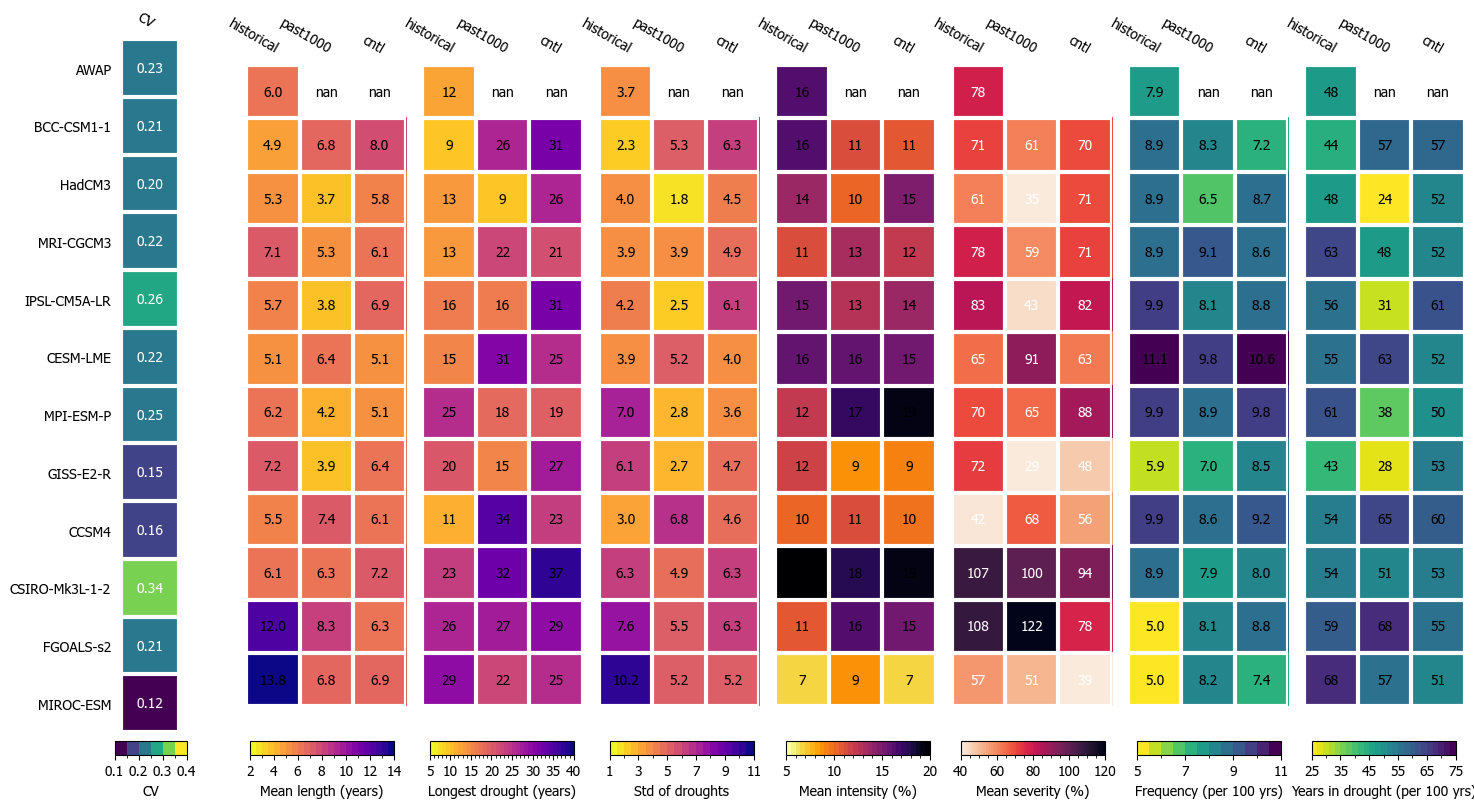

In [21]:
models = ['AWAP', 'BCC-CSM1-1', 'HadCM3', 'MRI-CGCM3', 'IPSL-CM5A-LR', 'CESM-LME', 'MPI-ESM-P',
          'GISS-E2-R', 'CCSM4','CSIRO-Mk3L-1-2', 'FGOALS-s2', 'MIROC-ESM']

metric = ['CV', 'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl', 
          'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl']

col1_2 = 'droughts_2s2e_mean'
col3_4 = 'droughts_2s2e_max'
col5_6 = 'droughts_2s2e_std'
col7_8 = 'droughts_2s2e_intensity_pc_mean'
col9 = 'droughts_2s2e_severity_pc_mean'
col10 = 'droughts_2s2e_no_events_100yrs'
col11 = 'droughts_2s2e_sum_100yrs'

data_all = np.array([[awap_masked_annual_mdb.CV, awap_masked_annual_mdb[col1_2],     np.nan,                                    np.nan,                      awap_masked_annual_mdb[col3_4],     np.nan,                                   np.nan,                      awap_masked_annual_mdb[col5_6],     np.nan,                                   np.nan,                      awap_masked_annual_mdb[col7_8],     np.nan,                                   np.nan,                      awap_masked_annual_mdb[col9],     np.nan,                                  np.nan,                    awap_masked_annual_mdb[col10],     np.nan,                                  np.nan                    , awap_masked_annual_mdb[col11],     np.nan,                                   np.nan,                    ],
                     [bcc_precip_hist_mdb.CV,    bcc_precip_hist_mdb[col1_2],        bcc_precip_lm_mdb_pre1850[col1_2],         bcc_cntl_mdb[col1_2],        bcc_precip_hist_mdb[col3_4],        bcc_precip_lm_mdb_pre1850[col3_4],        bcc_cntl_mdb[col3_4],        bcc_precip_hist_mdb[col5_6],        bcc_precip_lm_mdb_pre1850[col5_6],        bcc_cntl_mdb[col5_6],        bcc_precip_hist_mdb[col7_8],        bcc_precip_lm_mdb_pre1850[col7_8],        bcc_cntl_mdb[col7_8],        bcc_precip_hist_mdb[col9],        bcc_precip_lm_mdb_pre1850[col9],         bcc_cntl_mdb[col9],        bcc_precip_hist_mdb[col10],        bcc_precip_lm_mdb_pre1850[col10],        bcc_cntl_mdb[col10]    ,    bcc_precip_hist_mdb[col11],        bcc_precip_lm_mdb_pre1850[col11],         bcc_cntl_mdb[col11]         ],
                 [hadcm3_precip_hist_mdb.CV,   hadcm3_precip_hist_mdb[col1_2],     hadcm3_precip_lm_mdb_pre1850[col1_2],      hadcm3_cntl_mdb[col1_2],     hadcm3_precip_hist_mdb[col3_4],     hadcm3_precip_lm_mdb_pre1850[col3_4],     hadcm3_cntl_mdb[col3_4],     hadcm3_precip_hist_mdb[col5_6],     hadcm3_precip_lm_mdb_pre1850[col5_6],     hadcm3_cntl_mdb[col5_6],     hadcm3_precip_hist_mdb[col7_8],     hadcm3_precip_lm_mdb_pre1850[col7_8],     hadcm3_cntl_mdb[col7_8],     hadcm3_precip_hist_mdb[col9],     hadcm3_precip_lm_mdb_pre1850[col9],      hadcm3_cntl_mdb[col9],     hadcm3_precip_hist_mdb[col10],     hadcm3_precip_lm_mdb_pre1850[col10],     hadcm3_cntl_mdb[col10]   ,  hadcm3_precip_hist_mdb[col11],     hadcm3_precip_lm_mdb_pre1850[col11],      hadcm3_cntl_mdb[col11]       ],
                 [mri_precip_hist_mdb.CV,      mri_precip_hist_mdb[col1_2],        mri_precip_lm_mdb_pre1850[col1_2],         mri_cntl_mdb[col1_2],        mri_precip_hist_mdb[col3_4],        mri_precip_lm_mdb_pre1850[col3_4],        mri_cntl_mdb[col3_4],        mri_precip_hist_mdb[col5_6],        mri_precip_lm_mdb_pre1850[col5_6],        mri_cntl_mdb[col5_6],        mri_precip_hist_mdb[col7_8],        mri_precip_lm_mdb_pre1850[col7_8],        mri_cntl_mdb[col7_8],        mri_precip_hist_mdb[col9],        mri_precip_lm_mdb_pre1850[col9],         mri_cntl_mdb[col9],        mri_precip_hist_mdb[col10],        mri_precip_lm_mdb_pre1850[col10],        mri_cntl_mdb[col10],        mri_precip_hist_mdb[col11],        mri_precip_lm_mdb_pre1850[col11],         mri_cntl_mdb[col11]  ], 
                 [ipsl_precip_hist_mdb.CV,     ipsl_precip_hist_mdb[col1_2],       ipsl_precip_lm_mdb_pre1850[col1_2],        ipsl_cntl_mdb[col1_2],       ipsl_precip_hist_mdb[col3_4],       ipsl_precip_lm_mdb_pre1850[col3_4],       ipsl_cntl_mdb[col3_4],       ipsl_precip_hist_mdb[col5_6],       ipsl_precip_lm_mdb_pre1850[col5_6],       ipsl_cntl_mdb[col5_6],       ipsl_precip_hist_mdb[col7_8],       ipsl_precip_lm_mdb_pre1850[col7_8],       ipsl_cntl_mdb[col7_8],       ipsl_precip_hist_mdb[col9],       ipsl_precip_lm_mdb_pre1850[col9],        ipsl_cntl_mdb[col9],       ipsl_precip_hist_mdb[col10],       ipsl_precip_lm_mdb_pre1850[col10],       ipsl_cntl_mdb[col10] ,      ipsl_precip_hist_mdb[col11],       ipsl_precip_lm_mdb_pre1850[col11],        ipsl_cntl_mdb[col11]   ],
                 [ff2_precip_hist_mdb.CV,      ff2_precip_hist_mdb[col1_2],        ff2_precip_lm_mdb_pre1850[col1_2],         cesmlme_cntl_mdb[col1_2],    ff2_precip_hist_mdb[col3_4],        ff2_precip_lm_mdb_pre1850[col3_4],        cesmlme_cntl_mdb[col3_4],    ff2_precip_hist_mdb[col5_6],        ff2_precip_lm_mdb_pre1850[col5_6],        cesmlme_cntl_mdb[col5_6],    ff2_precip_hist_mdb[col7_8],        ff2_precip_lm_mdb_pre1850[col7_8],        cesmlme_cntl_mdb[col7_8],    ff2_precip_hist_mdb[col9],        ff2_precip_lm_mdb_pre1850[col9],         cesmlme_cntl_mdb[col9],    ff2_precip_hist_mdb[col10],        ff2_precip_lm_mdb_pre1850[col10],        cesmlme_cntl_mdb[col10]    ,ff2_precip_hist_mdb[col11],        ff2_precip_lm_mdb_pre1850[col11],         cesmlme_cntl_mdb[col11]      ],
                 [mpi_precip_hist_mdb.CV,      mpi_precip_hist_mdb[col1_2],        mpi_precip_lm_mdb_pre1850[col1_2],         mpi_cntl_mdb[col1_2],        mpi_precip_hist_mdb[col3_4],        mpi_precip_lm_mdb_pre1850[col3_4],        mpi_cntl_mdb[col3_4],        mpi_precip_hist_mdb[col5_6],        mpi_precip_lm_mdb_pre1850[col5_6],        mpi_cntl_mdb[col5_6],        mpi_precip_hist_mdb[col7_8],        mpi_precip_lm_mdb_pre1850[col7_8],        mpi_cntl_mdb[col7_8],        mpi_precip_hist_mdb[col9],        mpi_precip_lm_mdb_pre1850[col9],         mpi_cntl_mdb[col9],        mpi_precip_hist_mdb[col10],        mpi_precip_lm_mdb_pre1850[col10],        mpi_cntl_mdb[col10]    ,    mpi_precip_hist_mdb[col11],        mpi_precip_lm_mdb_pre1850[col11],         mpi_cntl_mdb[col11]      ],
                 [giss_28_precip_hist_mdb.CV,  giss_28_precip_hist_mdb[col1_2],    giss_28_precip_lm_mdb_pre1850[col1_2],     giss_1_cntl_mdb[col1_2],     giss_28_precip_hist_mdb[col3_4],    giss_28_precip_lm_mdb_pre1850[col3_4],    giss_1_cntl_mdb[col3_4],     giss_28_precip_hist_mdb[col5_6],    giss_28_precip_lm_mdb_pre1850[col5_6],    giss_1_cntl_mdb[col5_6],     giss_28_precip_hist_mdb[col7_8],    giss_28_precip_lm_mdb_pre1850[col7_8],    giss_1_cntl_mdb[col7_8],     giss_28_precip_hist_mdb[col9],    giss_28_precip_lm_mdb_pre1850[col9],     giss_1_cntl_mdb[col9],     giss_28_precip_hist_mdb[col10],    giss_28_precip_lm_mdb_pre1850[col10],    giss_1_cntl_mdb[col10]  ,   giss_28_precip_hist_mdb[col11],    giss_28_precip_lm_mdb_pre1850[col11],     giss_1_cntl_mdb[col11]        ],
                 [ccsm4_precip_hist_mdb.CV,    ccsm4_precip_hist_mdb[col1_2],      ccsm4_precip_lm_mdb_pre1850[col1_2],       ccsm4_cntl_mdb[col1_2],      ccsm4_precip_hist_mdb[col3_4],      ccsm4_precip_lm_mdb_pre1850[col3_4],      ccsm4_cntl_mdb[col3_4],      ccsm4_precip_hist_mdb[col5_6],      ccsm4_precip_lm_mdb_pre1850[col5_6],      ccsm4_cntl_mdb[col5_6],      ccsm4_precip_hist_mdb[col7_8],      ccsm4_precip_lm_mdb_pre1850[col7_8],      ccsm4_cntl_mdb[col7_8],      ccsm4_precip_hist_mdb[col9],      ccsm4_precip_lm_mdb_pre1850[col9],       ccsm4_cntl_mdb[col9],      ccsm4_precip_hist_mdb[col10],      ccsm4_precip_lm_mdb_pre1850[col10],      ccsm4_cntl_mdb[col10]     , ccsm4_precip_hist_mdb[col11],      ccsm4_precip_lm_mdb_pre1850[col11],       ccsm4_cntl_mdb[col11]       ],
                 [csiro_mk3l_precip_hist_mdb.CV,csiro_mk3l_precip_hist_mdb[col1_2], csiro_mk3l_precip_lm_mdb_pre1850[col1_2],  csiro_mk3l_cntl_mdb[col1_2], csiro_mk3l_precip_hist_mdb[col3_4], csiro_mk3l_precip_lm_mdb_pre1850[col3_4], csiro_mk3l_cntl_mdb[col3_4], csiro_mk3l_precip_hist_mdb[col5_6], csiro_mk3l_precip_lm_mdb_pre1850[col5_6], csiro_mk3l_cntl_mdb[col5_6], csiro_mk3l_precip_hist_mdb[col7_8], csiro_mk3l_precip_lm_mdb_pre1850[col7_8], csiro_mk3l_cntl_mdb[col7_8], csiro_mk3l_precip_hist_mdb[col9], csiro_mk3l_precip_lm_mdb_pre1850[col9],  csiro_mk3l_cntl_mdb[col9], csiro_mk3l_precip_hist_mdb[col10], csiro_mk3l_precip_lm_mdb_pre1850[col10], csiro_mk3l_cntl_mdb[col10], csiro_mk3l_precip_hist_mdb[col11], csiro_mk3l_precip_lm_mdb_pre1850[col11],  csiro_mk3l_cntl_mdb[col11]         ],
                 [fgoals_s2_precip_hist_mdb.CV, fgoals_s2_precip_hist_mdb[col1_2],  fgoals_s2_precip_lm_mdb_pre1850[col1_2],   fgoals_s2_cntl_mdb[col1_2],  fgoals_s2_precip_hist_mdb[col3_4],  fgoals_s2_precip_lm_mdb_pre1850[col3_4],  fgoals_s2_cntl_mdb[col3_4],  fgoals_s2_precip_hist_mdb[col5_6],  fgoals_s2_precip_lm_mdb_pre1850[col5_6],  fgoals_s2_cntl_mdb[col5_6],  fgoals_s2_precip_hist_mdb[col7_8],  fgoals_s2_precip_lm_mdb_pre1850[col7_8],  fgoals_s2_cntl_mdb[col7_8],  fgoals_s2_precip_hist_mdb[col9],  fgoals_s2_precip_lm_mdb_pre1850[col9],   fgoals_s2_cntl_mdb[col9],  fgoals_s2_precip_hist_mdb[col10],  fgoals_s2_precip_lm_mdb_pre1850[col10],  fgoals_s2_cntl_mdb[col10] , fgoals_s2_precip_hist_mdb[col11],  fgoals_s2_precip_lm_mdb_pre1850[col11],   fgoals_s2_cntl_mdb[col11]         ],
                 [miroc_precip_hist_mdb.CV,     miroc_precip_hist_mdb[col1_2],      miroc_precip_lm_mdb_pre1850[col1_2],       miroc_cntl_mdb[col1_2],      miroc_precip_hist_mdb[col3_4],      miroc_precip_lm_mdb_pre1850[col3_4],      miroc_cntl_mdb[col3_4],      miroc_precip_hist_mdb[col5_6],      miroc_precip_lm_mdb_pre1850[col5_6],      miroc_cntl_mdb[col5_6],      miroc_precip_hist_mdb[col7_8],      miroc_precip_lm_mdb_pre1850[col7_8],      miroc_cntl_mdb[col7_8],      miroc_precip_hist_mdb[col9],      miroc_precip_lm_mdb_pre1850[col9],       miroc_cntl_mdb[col9],      miroc_precip_hist_mdb[col10],      miroc_precip_lm_mdb_pre1850[col10],      miroc_cntl_mdb[col10],      miroc_precip_hist_mdb[col11],      miroc_precip_lm_mdb_pre1850[col11],       miroc_cntl_mdb[col11]     ]])
 

CV_plot = data_all[:,0:1]
means_plot = data_all[:,1:4]
max_plot = data_all[:,4:7]
std_plot = data_all[:,7:10]
intensity_plot = data_all[:,10:13]
severity_plot = data_all[:,13:16]
events_plot = data_all[:,16:19]
risk_plot = data_all[:,19:22]
cbar_height = 0.015
cbar_length = 0.08

# ----------------------------------------------------------
# --- initial
fig, ax = plt.subplots(1, 8, sharey=True, figsize=(18,9))
plt.subplots_adjust(wspace=0.1)


# --- first columns
ax_n = 0
data = CV_plot
xlabels = metric[0:1]
valfmt="{x:.2f}"

contour_levels = np.arange(0.1, 0.45, 0.05)
cmaps = plt.cm.get_cmap('viridis')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

# Plot the heatmap
im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms )
cax = fig.add_axes([0.15, 0.085, 0.04, cbar_height])
# Create colorbar
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.03, ticks=np.arange(0.1,0.5,0.1))
cbar.ax.xaxis.set_ticks(np.arange(0.1, 0.45, 0.05), minor=True)
cbar.set_label('CV')

# ticks & abels
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_yticks(np.arange(data.shape[0]))
ax[ax_n].set_xticklabels(xlabels)
ax[ax_n].set_yticklabels(models)

ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on top of plot
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor") # Rotate the tick labels and set their alignment.

# Turn spines off and create white grid.
for edge, spine in ax[0].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'white')

# ------ second column
ax_n = 1
data = means_plot
xlabels = metric[1:4]
valfmt="{x:.1f}"

contour_levels = np.arange(2, 14.5, 0.5)
cmaps = plt.cm.get_cmap('plasma_r')

norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im1 = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax2 = fig.add_axes([0.225, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im1, cax=cax2, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(2,16,2))
cbar.set_label('Mean length (years)')
cbar.ax.xaxis.set_ticks(np.arange(2, 14, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(metric[1:4])
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im1, data, valfmt, 'black')

# # # --- third column
ax_n=2
data = max_plot
labels = metric[4:7]
valfmt="{x:.0f}"

contour_levels = np.arange(5, 41, 1)
cmaps = plt.cm.get_cmap('plasma_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.325, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(5, 45, 5))
cbar.set_label('Longest drought (years)')
cbar.ax.xaxis.set_ticks(np.arange(5, 41, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

# # # # --- fourth column
ax_n = 3
data = std_plot
labels = metric[7:10]
valfmt="{x:.1f}"
contour_levels = np.arange(1, 11.5, 0.5)
cmaps = plt.cm.get_cmap('plasma_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.425, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(1,13,2))
cbar.set_label('Std of droughts')
cbar.ax.xaxis.set_ticks(np.arange(1, 12, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

# fourth column
ax_n = 4
data = intensity_plot
labels = metric[10:13]
valfmt="{x:.0f}"
contour_levels = np.arange(5, 20.5, 0.5)
cmaps = plt.cm.get_cmap('inferno_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.523, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=[5,10,15,20])
cbar.set_label('Mean intensity (%)')
cbar.ax.xaxis.set_ticks(np.arange(5, 20, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

# ----------------
# fourth column
ax_n = 5
data = severity_plot
labels = metric[13:16]
valfmt="{x:.0f}"
contour_levels = np.arange(40, 121, 1)
cmaps = plt.cm.get_cmap('rocket_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.62, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(40, 140, 20))
cbar.set_label('Mean severity (%)')
cbar.ax.xaxis.set_ticks(np.arange(40, 120, 5), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'white')

# fifth column
ax_n=6
data = events_plot

labels = metric[16:19]
valfmt="{x:.1f}"
contour_levels = np.arange(5, 11.5, 0.5)
cmaps = plt.cm.get_cmap('viridis_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.718, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(5,12,2))
cbar.set_label('Frequency (per 100 yrs)')
cbar.ax.xaxis.set_ticks(np.arange(5, 12, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

# fifth column
ax_n=7
data = risk_plot

labels = metric[19:22]
valfmt="{x:.0f}"
contour_levels = np.arange(25, 76, 2)
cmaps = plt.cm.get_cmap('viridis_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.815, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(25, 85, 10))
cbar.ax.xaxis.set_ticks(np.arange(30, 80, 10), minor=True)
cbar.set_label('Years in drought (per 100 yrs)')

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

#plt.savefig('mdb_hm_2s2e_lm-with_CV.pdf', bbox_inches='tight')
plt.show()

### Or showing MAP

meta NOT subset; don't know how to subset; dropped


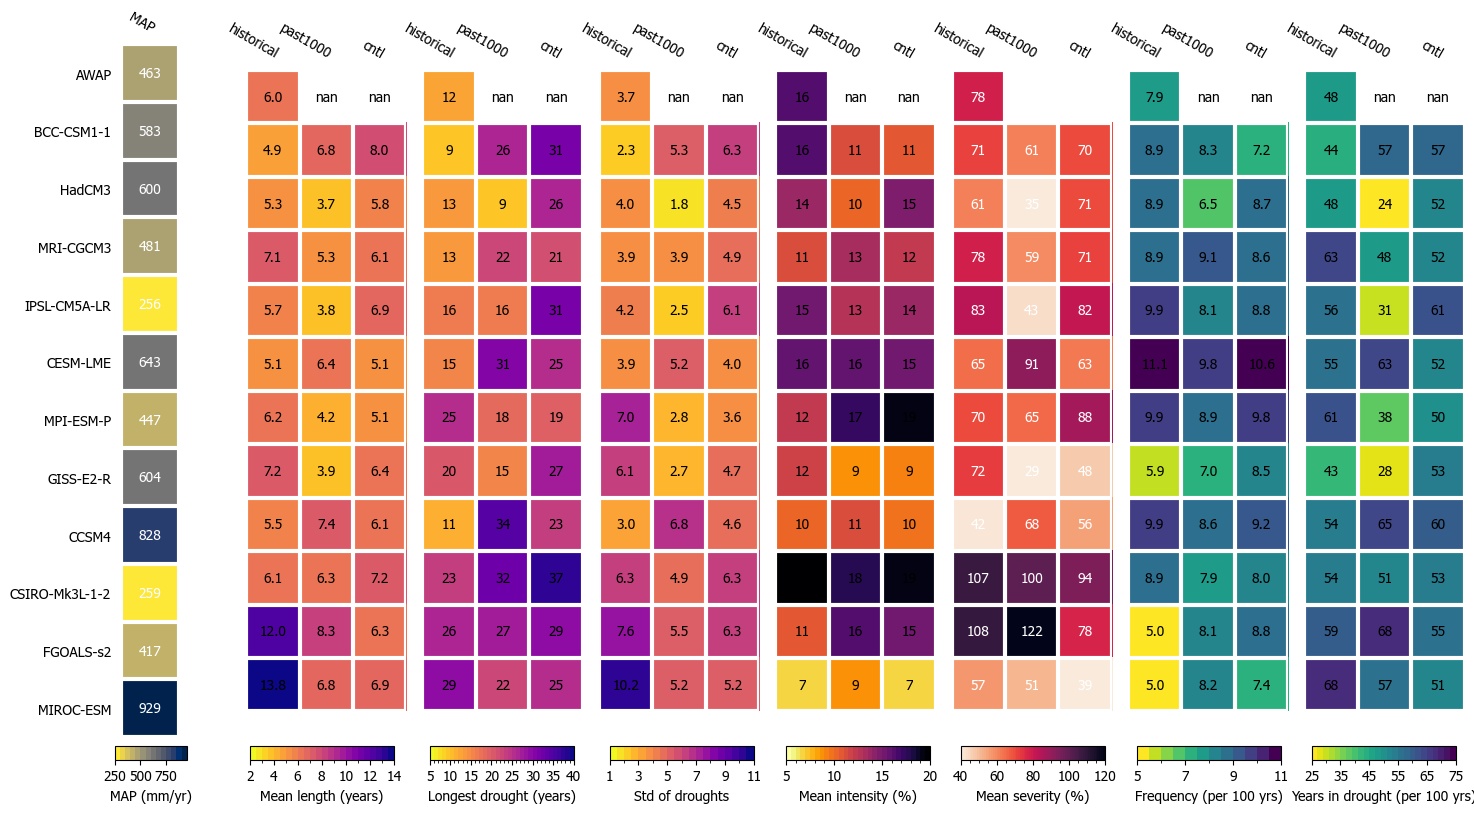

In [22]:
models = ['AWAP', 'BCC-CSM1-1', 'HadCM3', 'MRI-CGCM3', 'IPSL-CM5A-LR', 'CESM-LME', 'MPI-ESM-P',
          'GISS-E2-R', 'CCSM4','CSIRO-Mk3L-1-2', 'FGOALS-s2', 'MIROC-ESM']

metric = ['MAP', 'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl', 
          'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl',
          'historical', 'past1000', 'cntl']

col1_2 = 'droughts_2s2e_mean'
col3_4 = 'droughts_2s2e_max'
col5_6 = 'droughts_2s2e_std'
col7_8 = 'droughts_2s2e_intensity_pc_mean'
col9 = 'droughts_2s2e_severity_pc_mean'
col10 = 'droughts_2s2e_no_events_100yrs'
col11 = 'droughts_2s2e_sum_100yrs'

data_all = np.array([[awap_masked_annual_mdb.MAP, awap_masked_annual_mdb[col1_2],     np.nan,                                    np.nan,                      awap_masked_annual_mdb[col3_4],     np.nan,                                   np.nan,                      awap_masked_annual_mdb[col5_6],     np.nan,                                   np.nan,                      awap_masked_annual_mdb[col7_8],     np.nan,                                   np.nan,                      awap_masked_annual_mdb[col9],     np.nan,                                  np.nan,                    awap_masked_annual_mdb[col10],     np.nan,                                  np.nan                    , awap_masked_annual_mdb[col11],     np.nan,                                   np.nan,                    ],
                     [bcc_precip_hist_mdb.MAP,    bcc_precip_hist_mdb[col1_2],        bcc_precip_lm_mdb_pre1850[col1_2],         bcc_cntl_mdb[col1_2],        bcc_precip_hist_mdb[col3_4],        bcc_precip_lm_mdb_pre1850[col3_4],        bcc_cntl_mdb[col3_4],        bcc_precip_hist_mdb[col5_6],        bcc_precip_lm_mdb_pre1850[col5_6],        bcc_cntl_mdb[col5_6],        bcc_precip_hist_mdb[col7_8],        bcc_precip_lm_mdb_pre1850[col7_8],        bcc_cntl_mdb[col7_8],        bcc_precip_hist_mdb[col9],        bcc_precip_lm_mdb_pre1850[col9],         bcc_cntl_mdb[col9],        bcc_precip_hist_mdb[col10],        bcc_precip_lm_mdb_pre1850[col10],        bcc_cntl_mdb[col10]    ,    bcc_precip_hist_mdb[col11],        bcc_precip_lm_mdb_pre1850[col11],         bcc_cntl_mdb[col11]         ],
                 [hadcm3_precip_hist_mdb.MAP,   hadcm3_precip_hist_mdb[col1_2],     hadcm3_precip_lm_mdb_pre1850[col1_2],      hadcm3_cntl_mdb[col1_2],     hadcm3_precip_hist_mdb[col3_4],     hadcm3_precip_lm_mdb_pre1850[col3_4],     hadcm3_cntl_mdb[col3_4],     hadcm3_precip_hist_mdb[col5_6],     hadcm3_precip_lm_mdb_pre1850[col5_6],     hadcm3_cntl_mdb[col5_6],     hadcm3_precip_hist_mdb[col7_8],     hadcm3_precip_lm_mdb_pre1850[col7_8],     hadcm3_cntl_mdb[col7_8],     hadcm3_precip_hist_mdb[col9],     hadcm3_precip_lm_mdb_pre1850[col9],      hadcm3_cntl_mdb[col9],     hadcm3_precip_hist_mdb[col10],     hadcm3_precip_lm_mdb_pre1850[col10],     hadcm3_cntl_mdb[col10]   ,  hadcm3_precip_hist_mdb[col11],     hadcm3_precip_lm_mdb_pre1850[col11],      hadcm3_cntl_mdb[col11]       ],
                 [mri_precip_hist_mdb.MAP,      mri_precip_hist_mdb[col1_2],        mri_precip_lm_mdb_pre1850[col1_2],         mri_cntl_mdb[col1_2],        mri_precip_hist_mdb[col3_4],        mri_precip_lm_mdb_pre1850[col3_4],        mri_cntl_mdb[col3_4],        mri_precip_hist_mdb[col5_6],        mri_precip_lm_mdb_pre1850[col5_6],        mri_cntl_mdb[col5_6],        mri_precip_hist_mdb[col7_8],        mri_precip_lm_mdb_pre1850[col7_8],        mri_cntl_mdb[col7_8],        mri_precip_hist_mdb[col9],        mri_precip_lm_mdb_pre1850[col9],         mri_cntl_mdb[col9],        mri_precip_hist_mdb[col10],        mri_precip_lm_mdb_pre1850[col10],        mri_cntl_mdb[col10],        mri_precip_hist_mdb[col11],        mri_precip_lm_mdb_pre1850[col11],         mri_cntl_mdb[col11]  ], 
                 [ipsl_precip_hist_mdb.MAP,     ipsl_precip_hist_mdb[col1_2],       ipsl_precip_lm_mdb_pre1850[col1_2],        ipsl_cntl_mdb[col1_2],       ipsl_precip_hist_mdb[col3_4],       ipsl_precip_lm_mdb_pre1850[col3_4],       ipsl_cntl_mdb[col3_4],       ipsl_precip_hist_mdb[col5_6],       ipsl_precip_lm_mdb_pre1850[col5_6],       ipsl_cntl_mdb[col5_6],       ipsl_precip_hist_mdb[col7_8],       ipsl_precip_lm_mdb_pre1850[col7_8],       ipsl_cntl_mdb[col7_8],       ipsl_precip_hist_mdb[col9],       ipsl_precip_lm_mdb_pre1850[col9],        ipsl_cntl_mdb[col9],       ipsl_precip_hist_mdb[col10],       ipsl_precip_lm_mdb_pre1850[col10],       ipsl_cntl_mdb[col10] ,      ipsl_precip_hist_mdb[col11],       ipsl_precip_lm_mdb_pre1850[col11],        ipsl_cntl_mdb[col11]   ],
                 [ff2_precip_hist_mdb.MAP,      ff2_precip_hist_mdb[col1_2],        ff2_precip_lm_mdb_pre1850[col1_2],         cesmlme_cntl_mdb[col1_2],    ff2_precip_hist_mdb[col3_4],        ff2_precip_lm_mdb_pre1850[col3_4],        cesmlme_cntl_mdb[col3_4],    ff2_precip_hist_mdb[col5_6],        ff2_precip_lm_mdb_pre1850[col5_6],        cesmlme_cntl_mdb[col5_6],    ff2_precip_hist_mdb[col7_8],        ff2_precip_lm_mdb_pre1850[col7_8],        cesmlme_cntl_mdb[col7_8],    ff2_precip_hist_mdb[col9],        ff2_precip_lm_mdb_pre1850[col9],         cesmlme_cntl_mdb[col9],    ff2_precip_hist_mdb[col10],        ff2_precip_lm_mdb_pre1850[col10],        cesmlme_cntl_mdb[col10]    ,ff2_precip_hist_mdb[col11],        ff2_precip_lm_mdb_pre1850[col11],         cesmlme_cntl_mdb[col11]      ],
                 [mpi_precip_hist_mdb.MAP,      mpi_precip_hist_mdb[col1_2],        mpi_precip_lm_mdb_pre1850[col1_2],         mpi_cntl_mdb[col1_2],        mpi_precip_hist_mdb[col3_4],        mpi_precip_lm_mdb_pre1850[col3_4],        mpi_cntl_mdb[col3_4],        mpi_precip_hist_mdb[col5_6],        mpi_precip_lm_mdb_pre1850[col5_6],        mpi_cntl_mdb[col5_6],        mpi_precip_hist_mdb[col7_8],        mpi_precip_lm_mdb_pre1850[col7_8],        mpi_cntl_mdb[col7_8],        mpi_precip_hist_mdb[col9],        mpi_precip_lm_mdb_pre1850[col9],         mpi_cntl_mdb[col9],        mpi_precip_hist_mdb[col10],        mpi_precip_lm_mdb_pre1850[col10],        mpi_cntl_mdb[col10]    ,    mpi_precip_hist_mdb[col11],        mpi_precip_lm_mdb_pre1850[col11],         mpi_cntl_mdb[col11]      ],
                 [giss_28_precip_hist_mdb.MAP,  giss_28_precip_hist_mdb[col1_2],    giss_28_precip_lm_mdb_pre1850[col1_2],     giss_1_cntl_mdb[col1_2],     giss_28_precip_hist_mdb[col3_4],    giss_28_precip_lm_mdb_pre1850[col3_4],    giss_1_cntl_mdb[col3_4],     giss_28_precip_hist_mdb[col5_6],    giss_28_precip_lm_mdb_pre1850[col5_6],    giss_1_cntl_mdb[col5_6],     giss_28_precip_hist_mdb[col7_8],    giss_28_precip_lm_mdb_pre1850[col7_8],    giss_1_cntl_mdb[col7_8],     giss_28_precip_hist_mdb[col9],    giss_28_precip_lm_mdb_pre1850[col9],     giss_1_cntl_mdb[col9],     giss_28_precip_hist_mdb[col10],    giss_28_precip_lm_mdb_pre1850[col10],    giss_1_cntl_mdb[col10]  ,   giss_28_precip_hist_mdb[col11],    giss_28_precip_lm_mdb_pre1850[col11],     giss_1_cntl_mdb[col11]        ],
                 [ccsm4_precip_hist_mdb.MAP,    ccsm4_precip_hist_mdb[col1_2],      ccsm4_precip_lm_mdb_pre1850[col1_2],       ccsm4_cntl_mdb[col1_2],      ccsm4_precip_hist_mdb[col3_4],      ccsm4_precip_lm_mdb_pre1850[col3_4],      ccsm4_cntl_mdb[col3_4],      ccsm4_precip_hist_mdb[col5_6],      ccsm4_precip_lm_mdb_pre1850[col5_6],      ccsm4_cntl_mdb[col5_6],      ccsm4_precip_hist_mdb[col7_8],      ccsm4_precip_lm_mdb_pre1850[col7_8],      ccsm4_cntl_mdb[col7_8],      ccsm4_precip_hist_mdb[col9],      ccsm4_precip_lm_mdb_pre1850[col9],       ccsm4_cntl_mdb[col9],      ccsm4_precip_hist_mdb[col10],      ccsm4_precip_lm_mdb_pre1850[col10],      ccsm4_cntl_mdb[col10]     , ccsm4_precip_hist_mdb[col11],      ccsm4_precip_lm_mdb_pre1850[col11],       ccsm4_cntl_mdb[col11]       ],
                 [csiro_mk3l_precip_hist_mdb.MAP,csiro_mk3l_precip_hist_mdb[col1_2], csiro_mk3l_precip_lm_mdb_pre1850[col1_2],  csiro_mk3l_cntl_mdb[col1_2], csiro_mk3l_precip_hist_mdb[col3_4], csiro_mk3l_precip_lm_mdb_pre1850[col3_4], csiro_mk3l_cntl_mdb[col3_4], csiro_mk3l_precip_hist_mdb[col5_6], csiro_mk3l_precip_lm_mdb_pre1850[col5_6], csiro_mk3l_cntl_mdb[col5_6], csiro_mk3l_precip_hist_mdb[col7_8], csiro_mk3l_precip_lm_mdb_pre1850[col7_8], csiro_mk3l_cntl_mdb[col7_8], csiro_mk3l_precip_hist_mdb[col9], csiro_mk3l_precip_lm_mdb_pre1850[col9],  csiro_mk3l_cntl_mdb[col9], csiro_mk3l_precip_hist_mdb[col10], csiro_mk3l_precip_lm_mdb_pre1850[col10], csiro_mk3l_cntl_mdb[col10], csiro_mk3l_precip_hist_mdb[col11], csiro_mk3l_precip_lm_mdb_pre1850[col11],  csiro_mk3l_cntl_mdb[col11]         ],
                 [fgoals_s2_precip_hist_mdb.MAP, fgoals_s2_precip_hist_mdb[col1_2],  fgoals_s2_precip_lm_mdb_pre1850[col1_2],   fgoals_s2_cntl_mdb[col1_2],  fgoals_s2_precip_hist_mdb[col3_4],  fgoals_s2_precip_lm_mdb_pre1850[col3_4],  fgoals_s2_cntl_mdb[col3_4],  fgoals_s2_precip_hist_mdb[col5_6],  fgoals_s2_precip_lm_mdb_pre1850[col5_6],  fgoals_s2_cntl_mdb[col5_6],  fgoals_s2_precip_hist_mdb[col7_8],  fgoals_s2_precip_lm_mdb_pre1850[col7_8],  fgoals_s2_cntl_mdb[col7_8],  fgoals_s2_precip_hist_mdb[col9],  fgoals_s2_precip_lm_mdb_pre1850[col9],   fgoals_s2_cntl_mdb[col9],  fgoals_s2_precip_hist_mdb[col10],  fgoals_s2_precip_lm_mdb_pre1850[col10],  fgoals_s2_cntl_mdb[col10] , fgoals_s2_precip_hist_mdb[col11],  fgoals_s2_precip_lm_mdb_pre1850[col11],   fgoals_s2_cntl_mdb[col11]         ],
                 [miroc_precip_hist_mdb.MAP,     miroc_precip_hist_mdb[col1_2],      miroc_precip_lm_mdb_pre1850[col1_2],       miroc_cntl_mdb[col1_2],      miroc_precip_hist_mdb[col3_4],      miroc_precip_lm_mdb_pre1850[col3_4],      miroc_cntl_mdb[col3_4],      miroc_precip_hist_mdb[col5_6],      miroc_precip_lm_mdb_pre1850[col5_6],      miroc_cntl_mdb[col5_6],      miroc_precip_hist_mdb[col7_8],      miroc_precip_lm_mdb_pre1850[col7_8],      miroc_cntl_mdb[col7_8],      miroc_precip_hist_mdb[col9],      miroc_precip_lm_mdb_pre1850[col9],       miroc_cntl_mdb[col9],      miroc_precip_hist_mdb[col10],      miroc_precip_lm_mdb_pre1850[col10],      miroc_cntl_mdb[col10],      miroc_precip_hist_mdb[col11],      miroc_precip_lm_mdb_pre1850[col11],       miroc_cntl_mdb[col11]     ]])
 

MAP_plot = data_all[:,0:1]
means_plot = data_all[:,1:4]
max_plot = data_all[:,4:7]
std_plot = data_all[:,7:10]
intensity_plot = data_all[:,10:13]
severity_plot = data_all[:,13:16]
events_plot = data_all[:,16:19]
risk_plot = data_all[:,19:22]
cbar_height = 0.015
cbar_length = 0.08

# ----------------------------------------------------------
# --- initial
fig, ax = plt.subplots(1, 8, sharey=True, figsize=(18,9))
plt.subplots_adjust(wspace=0.1)


# --- first columns
ax_n = 0
data = MAP_plot
xlabels = metric[0:1]
valfmt="{x:.0f}"

contour_levels = np.arange(250, 951, 50)
# cmaps = palette 
cmaps = plt.cm.get_cmap('cividis_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

# Plot the heatmap
im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms )
cax = fig.add_axes([0.15, 0.085, 0.04, cbar_height])
# Create colorbar
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.03, ticks=np.arange(250, 951, 250))
cbar.ax.xaxis.set_ticks(np.arange(250, 951, 250), minor=True)
cbar.set_label('MAP (mm/yr)')

# ticks & abels
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_yticks(np.arange(data.shape[0]))
ax[ax_n].set_xticklabels(xlabels)
ax[ax_n].set_yticklabels(models)

ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on top of plot
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor") # Rotate the tick labels and set their alignment.

# Turn spines off and create white grid.
for edge, spine in ax[0].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'white')

# ------ second column
ax_n = 1
data = means_plot
xlabels = metric[1:4]
valfmt="{x:.1f}"
# cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/temperature-1.cpt')
# palette = LinearSegmentedColormap('my_colormap', cpt)

contour_levels = np.arange(2, 14.5, 0.5)
cmaps = plt.cm.get_cmap('plasma_r')

norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im1 = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax2 = fig.add_axes([0.225, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im1, cax=cax2, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(2,16,2))
# cbar.ax.set_xlabel('years', rotation=0, va="bottom")
cbar.set_label('Mean length (years)')
cbar.ax.xaxis.set_ticks(np.arange(2, 14, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(metric[1:4])
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(means_plot.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im1, data, valfmt, 'black')

# # # --- third column
ax_n=2
data = max_plot
labels = metric[4:7]
valfmt="{x:.0f}"

contour_levels = np.arange(5, 41, 1)
cmaps = plt.cm.get_cmap('plasma_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.325, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(5, 45, 5))
# cbar.ax.set_xlabel('years', rotation=0, va="bottom")
cbar.set_label('Longest drought (years)')
cbar.ax.xaxis.set_ticks(np.arange(5, 41, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

# # # # --- fourth column
ax_n = 3
data = std_plot
labels = metric[7:10]
valfmt="{x:.1f}"
contour_levels = np.arange(1, 11.5, 0.5)
cmaps = plt.cm.get_cmap('plasma_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.425, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(1,13,2))
cbar.set_label('Std of droughts')
cbar.ax.xaxis.set_ticks(np.arange(1, 12, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

# fourth column
ax_n = 4
data = intensity_plot
labels = metric[10:13]
valfmt="{x:.0f}"
contour_levels = np.arange(5, 20.5, 0.5)
cmaps = plt.cm.get_cmap('inferno_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.523, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=[5,10,15,20])
cbar.set_label('Mean intensity (%)')
cbar.ax.xaxis.set_ticks(np.arange(5, 20, 1), minor=True)


# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

# ----------------
# fourth column
ax_n = 5
data = severity_plot
labels = metric[13:16]
valfmt="{x:.0f}"
contour_levels = np.arange(40, 121, 1)
cmaps = plt.cm.get_cmap('rocket_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.62, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(40, 140, 20))
cbar.set_label('Mean severity (%)')
cbar.ax.xaxis.set_ticks(np.arange(40, 120, 5), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'white')

# fifth column
ax_n=6
data = events_plot

labels = metric[16:19]
valfmt="{x:.1f}"
contour_levels = np.arange(5, 11.5, 0.5)
cmaps = plt.cm.get_cmap('viridis_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.718, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(5,12,2))
cbar.set_label('Frequency (per 100 yrs)')
cbar.ax.xaxis.set_ticks(np.arange(5, 12, 1), minor=True)

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

# fifth column
ax_n=7
data = risk_plot

labels = metric[19:22]
valfmt="{x:.0f}"
contour_levels = np.arange(25, 76, 2)
cmaps = plt.cm.get_cmap('viridis_r')
norms = BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)

im = ax[ax_n].imshow(data, cmap=cmaps, norm=norms)
# Create colorbar
cax = fig.add_axes([0.815, 0.085, cbar_length, cbar_height])  # x, y, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', fraction=0.1, aspect=10, pad=0.0, ticks=np.arange(25, 85, 10))
cbar.ax.xaxis.set_ticks(np.arange(30, 80, 10), minor=True)
cbar.set_label('Years in drought (per 100 yrs)')

# We want to show all ticks...
ax[ax_n].set_xticks(np.arange(data.shape[1]))
ax[ax_n].set_xticklabels(labels)
ax[ax_n].tick_params(top=False, bottom=False, labeltop=True, labelbottom=False, left=False) # ticks on plot

# Rotate the tick labels and set their alignment.
plt.setp(ax[ax_n].get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax[ax_n].spines.items():
    spine.set_visible(False)

ax[ax_n].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[ax_n].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax[ax_n].grid(which="minor", color="w", linestyle='-', linewidth=3)
ax[ax_n].tick_params(which="minor", bottom=False, left=False)

plot_text(im, data, valfmt, 'black')

#plt.savefig('mdb_hm_2s2e_lm-with_MAP.pdf', bbox_inches='tight')
plt.show()